## SVM、GridSearch、Kfold、

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best parameters found: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation AUC: 0.9628
Test AUC: 0.9573321263989466
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       448
           1       0.88      0.93      0.90       434

    accuracy                           0.90       882
   macro avg       0.90      0.90      0.90       882
weighted avg       0.90      0.90      0.90       882

Cross-Validation AUC Scores: [0.95833333 0.985954   0.96436652 0.95607089 0.97351056 0.97850679
 0.94334999 0.9538128  0.96240244 0.95174186]
Mean Cross-Validation AUC: 0.9628049166257568
過学習の可能性があります: Cross-Validation AUCがTest AUCを0.0054728だけ上回っています。


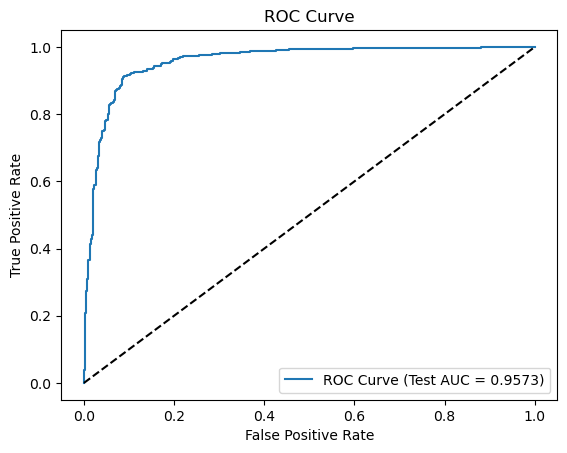

NameError: name 'joblib' is not defined

In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_SMOTE_0816.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'FamilySize', 'ChildCount', 'MaritalStatus', 'CityTier_Income_Ratio', 
    'CityTier','Pitched_Product_Status_Interaction', 'MonthlyIncome', 
    'Visits_to_Income_Ratio', 'Age_MonthlyIncome_Interaction',
    'Age_DurationOfPitch', 'Satisfaction_PerVisitor', 'PitchSatisfactionScore', 
    'CityTier_Visit_Interaction', 'DurationOfPitch', 'ChildCount_ProdTaken_Mean', 
    'ProductPitchedScore', 'Income_Binned_Very Low', 'Age', 'StatusScore', 
    'ProductPitched_Standard'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVMモデルの定義
svm_model = SVC(probability=True, random_state=40)

# ハイパーパラメータの候補を設定
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

# グリッドサーチの設定
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1)

# トレーニングデータでグリッドサーチを実行
svm_grid_search.fit(X_train_scaled, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {svm_grid_search.best_params_}")
print(f"Best cross-validation AUC: {svm_grid_search.best_score_:.4f}")

# 最適なモデルを取得
svm_best = svm_grid_search.best_estimator_

# テストデータでの予測とAUC計算
y_pred_proba = svm_best.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 評価レポートの表示
y_pred = svm_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# クロスバリデーションのAUCスコア計算
cv_scores = cross_val_score(svm_best, X_train_scaled, y_train, cv=kfold, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = '/Users/hayakawakazue/Downloads/signate/model/svc_best0816_3.joblib'
joblib.dump(svm_best, model_path)
print(f"最適なロジスティック回帰モデルが {model_path} に保存されました。") 

## 閾値を設定し重要な特徴量を可視化する

Model's most important features:
                   Feature   Coefficient
0   NumberOfPersonVisiting -2.146918e-02
1        NumberOfFollowups  3.907869e-02
2    PreferredPropertyStar  2.331866e-02
3            NumberOfTrips  4.658880e-02
4                 Passport  1.734936e-01
..                     ...           ...
59          AgeGroup_50-54 -2.906380e-02
60          AgeGroup_55-59 -4.915296e-03
61          AgeGroup_60-64  4.163336e-16
62     ProductPitchedScore  3.655812e-02
63             StatusScore -1.191791e-01

[64 rows x 2 columns]


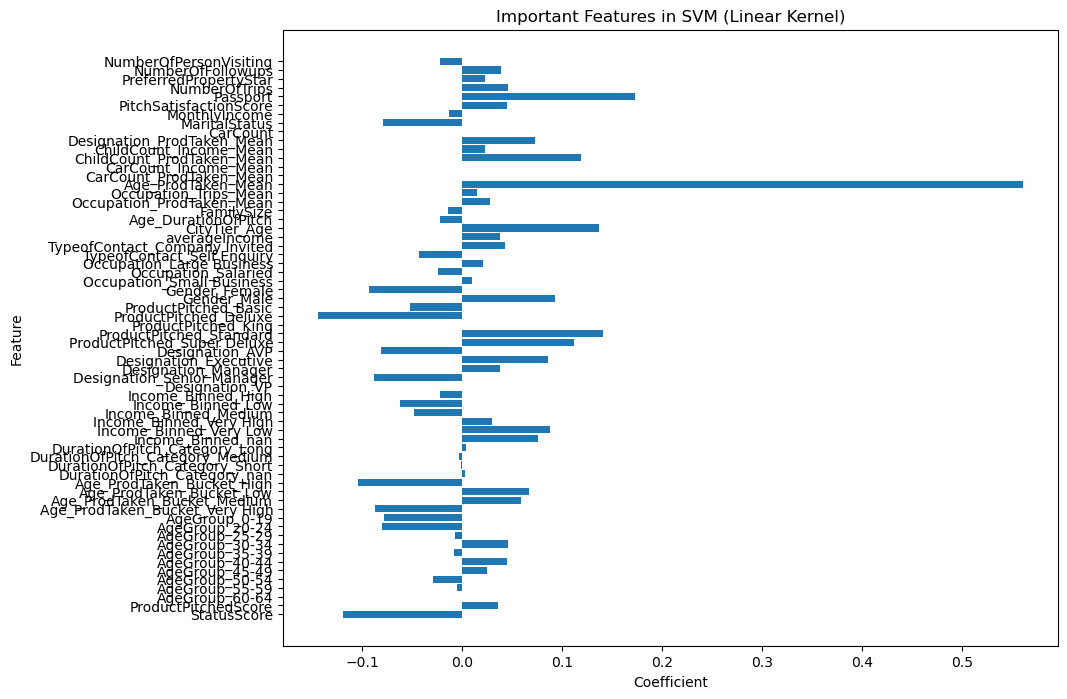

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])  # 全ての特徴量を利用
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 特徴量名を取得
selected_features = X.columns.tolist()

# 線形カーネルを持つSVMモデルの定義
svm_model = SVC(kernel='linear', probability=True, random_state=40)

# モデルのトレーニング
svm_model.fit(X_train_scaled, y_train)

# モデルの係数を取得
coefficients = svm_model.coef_[0]

# 特徴量名と係数を結びつける
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

# しきい値を設定して重要な特徴量だけを選択
threshold = 0.1  # ここでしきい値を設定
important_features_df = feature_importance_df[np.abs(feature_importance_df['Coefficient']) > threshold].copy()

# 係数の絶対値でソート
important_features_df['AbsCoefficient'] = np.abs(important_features_df['Coefficient'])
important_features_df = important_features_df.sort_values(by='AbsCoefficient', ascending=False)

# 重要な特徴量のリストを表示
print("Model's most important features:")
print(feature_importance_df[['Feature', 'Coefficient']])

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Important Features in SVM (Linear Kernel)')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()


## 上位20の特徴量を確認する

Model's top 20 most important features:
                               Feature  Coefficient
6         Occupation_ProdTaken_Mean_CV    -0.767501
27           Occupation_Large Business     0.519562
28                 Occupation_Salaried    -0.497140
8     ProductPitched_ProdTaken_Mean_CV    -0.426253
69  Pitched_Product_Status_Interaction    -0.377271
14               Age_ProdTaken_Mean_CV     0.339608
9           Designation_Income_Mean_CV    -0.299939
36         ProductPitched_Super Deluxe     0.283976
2                             Passport     0.270372
33               ProductPitched_Deluxe    -0.247242
30                       Gender_Female    -0.210062
31                         Gender_Male     0.210062
70           Gender_Income_Interaction    -0.198214
24               CityTier_Income_Ratio     0.181254
29           Occupation_Small Business     0.174150
55      Age_ProdTaken_Bucket_Very High    -0.169278
37                     Designation_AVP     0.167573
53            Age_ProdTa

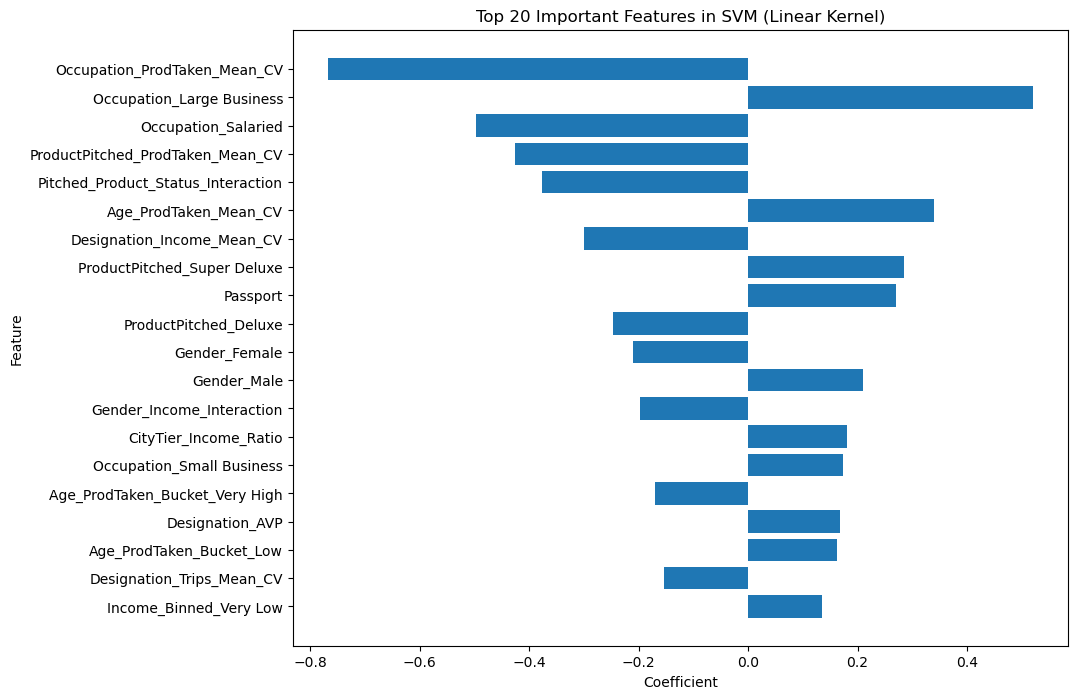

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features0817.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])  # 全ての特徴量を利用
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 特徴量名を取得
selected_features = X.columns.tolist()

# 線形カーネルを持つSVMモデルの定義
svm_model = SVC(kernel='linear', probability=True, random_state=40)

# モデルのトレーニング
svm_model.fit(X_train_scaled, y_train)

# モデルの係数を取得
coefficients = svm_model.coef_[0]

# 特徴量名と係数を結びつける
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

# 係数の絶対値でソートしてトップ20を選択
feature_importance_df['AbsCoefficient'] = np.abs(feature_importance_df['Coefficient'])
top_20_features_df = feature_importance_df.sort_values(by='AbsCoefficient', ascending=False).head(20)

# トップ20の特徴量のリストを表示
print("Model's top 20 most important features:")
print(top_20_features_df[['Feature', 'Coefficient']])

# トップ20の特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(top_20_features_df['Feature'], top_20_features_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 20 Important Features in SVM (Linear Kernel)')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()


## ランダムサーチでSVMをトレーニングする

Fitting 20 folds for each of 10 candidates, totalling 200 fits
Best parameters found: {'kernel': 'linear', 'gamma': 0.01, 'C': 0.1}
Best cross-validation AUC: 0.8151
Test AUC: 0.8374098079980433
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       629
           1       0.31      0.80      0.44       104

    accuracy                           0.72       733
   macro avg       0.63      0.75      0.63       733
weighted avg       0.86      0.72      0.76       733

Cross-Validation AUC Scores: [0.87301587 0.89186508 0.7597471  0.83350896 0.82191781 0.79978925
 0.89041096 0.89567966 0.83974359 0.79700855 0.80555556 0.81837607
 0.76175214 0.84294872 0.70940171 0.81196581 0.83547009 0.75213675
 0.73504274 0.82692308]
Mean Cross-Validation AUC: 0.8151129739742753
過学習の兆候は見られません。


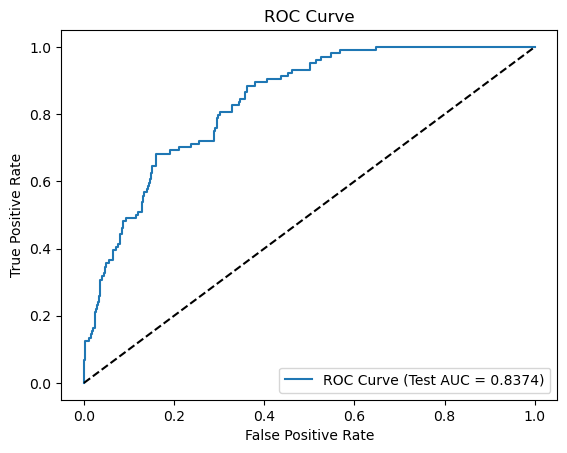

最適なロジスティック回帰モデルが /Users/hayakawakazue/Downloads/signate/model/svc_best0817_1.joblib に保存されました。


In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features0817.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Occupation_ProdTaken_Mean_CV', 'Occupation_Large Business', 'Occupation_Salaried', 
    'ProductPitched_ProdTaken_Mean_CV', 'Pitched_Product_Status_Interaction',
    'Age_ProdTaken_Mean_CV', 'Designation_Income_Mean_CV', 
    'ProductPitched_Super Deluxe', 'Passport',
    'ProductPitched_Deluxe', 'Gender_Female', 'Gender_Male', 
    'Gender_Income_Interaction', 'CityTier_Income_Ratio', 'Occupation_Small Business', 
    'Age_ProdTaken_Bucket_Very High', 'Designation_AVP', 'Age_ProdTaken_Bucket_Low',
    'Designation_Trips_Mean_CV', 'Income_Binned_Very Low'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVMモデルの定義
svm_model = SVC(probability=True, random_state=15, class_weight='balanced')

# ハイパーパラメータの候補を設定
param_dist = {
    'C': [ 0.01, 0.1],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.01, 'scale', 'auto']
}

# ランダムサーチの設定
kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=15)
svm_random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, n_iter=10, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=15)

# トレーニングデータでランダムサーチを実行
svm_random_search.fit(X_train_scaled, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {svm_random_search.best_params_}")
print(f"Best cross-validation AUC: {svm_random_search.best_score_:.4f}")

# 最適なモデルを取得
svm_best = svm_random_search.best_estimator_

# テストデータでの予測とAUC計算
y_pred_proba = svm_best.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 評価レポートの表示
y_pred = svm_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# クロスバリデーションのAUCスコア計算
cv_scores = cross_val_score(svm_best, X_train_scaled, y_train, cv=kfold, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# 最適なモデルの保存
model_path = '/Users/hayakawakazue/Downloads/signate/model/svc_best0817_1.joblib'
joblib.dump(svm_best, model_path)
print(f"最適なロジスティック回帰モデルが {model_path} に保存されました。")           
